In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.9


In [ ]:
file_path = 'DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]
print("Filtered dataset size:", len(df))
df.head()

Filtered dataset size: 12541


,Chromophore,Solvent,Quantum yield
34,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
43,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
71,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
72,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
73,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


In [ ]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [ ]:
import os
import torch

CACHE_FILE = "embedding_cache2.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {}  # empty cache

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [ ]:
from rdkit import Chem

def canonicalize_smiles(smiles):
    try:
        m = Chem.MolFromSmiles(smiles)
        if m is None:
            return None
        # isomericSmiles=True preserves stereochemistry
        return Chem.MolToSmiles(m, isomericSmiles=True)
    except Exception:
        return None

# update load_cache/save_cache as needed (they already exist)
# ...existing code...
def get_embeddings(smiles_list, batch_size=32, max_length=202):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cache = load_cache()
    # Build canonical mapping and preserve original order
    canon_list = []
    orig_to_canon = []
    for s in smiles_list:
        c = canonicalize_smiles(s)
        orig_to_canon.append(c)
        canon_list.append(c)

    # find new canon SMILES to compute (skip None)
    to_compute = [c for c in sorted(set(canon_list)) if c not in cache and c is not None]

    if to_compute:
        model.to(device)
        model.eval()
        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]
                inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
                outputs = model(**inputs)
                embeddings = outputs.pooler_output
                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()
        save_cache(cache)

    # Build ordered embeddings; for bad/None SMILES, fallback to zero vector
    emb_dim = next(iter(cache.values())).shape[0] if cache else outputs.pooler_output.shape[1]
    ordered = []
    for c in orig_to_canon:
        if c is None:
            ordered.append(torch.zeros(emb_dim))   # or handle by dropping row earlier
        else:
            ordered.append(cache[c])
    return torch.stack(ordered)

In [15]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

Chromophore embeddings shape: torch.Size([12541, 768])
Solvent embeddings shape: torch.Size([12541, 768])
Combined embedding shape: torch.Size([12541, 1536])


In [16]:
from sklearn.preprocessing import StandardScaler

chrom_emb_scaled = torch.tensor(StandardScaler().fit_transform(chrom_emb.numpy()), dtype=torch.float32)
solv_emb_scaled = torch.tensor(StandardScaler().fit_transform(solv_emb.numpy()), dtype=torch.float32)
combined_emb = torch.cat([chrom_emb_scaled, solv_emb_scaled], dim=1)

In [17]:
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)
X_train, X_test, y_train, y_test = train_test_split(combined_emb, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [18]:
#Transformer

In [19]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=512, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        chrom = self.embedding(chrom).unsqueeze(1)
        solv = self.embedding(solv).unsqueeze(1)
        x = torch.cat([chrom, solv], dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.regressor(x)

In [20]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb.shape[1]
transformer_model = TransformerRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # Split combined embedding back into chromophore and solvent
        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        
        # Forward pass
        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f}")

print("Training complete!")

Using device: cuda
Epoch 1/100 | Training Loss: 0.0793
Epoch 10/100 | Training Loss: 0.0240
Epoch 20/100 | Training Loss: 0.0137
Epoch 30/100 | Training Loss: 0.0097
Epoch 40/100 | Training Loss: 0.0074
Epoch 50/100 | Training Loss: 0.0060
Epoch 60/100 | Training Loss: 0.0055
Epoch 70/100 | Training Loss: 0.0045
Epoch 80/100 | Training Loss: 0.0039
Epoch 90/100 | Training Loss: 0.0036
Epoch 100/100 | Training Loss: 0.0032
Training complete!



=== Transformer Model Evaluation ===
R² Score: 0.6111
MAE: 0.1279
RMSE: 0.1871


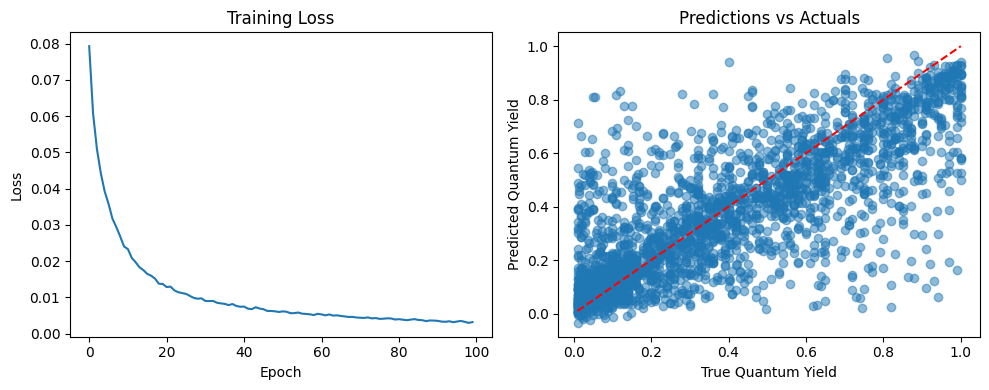

In [21]:
# Evaluation
transformer_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # Split combined embedding
        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        
        pred = transformer_model(chrom_batch, solv_batch)
        y_true.append(yb.cpu())
        y_pred.append(pred.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Transformer Model Evaluation ===")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Optional: Visualization

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Predictions vs Actuals")
plt.tight_layout()
plt.show()

In [ ]:
class CrossAttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        # Cross-attention layers
        self.cross_attn_layers = nn.ModuleList([
            nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        # Layer norms
        self.norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers * 2)
        ])
        
        # Feed-forward networks
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 4),
                nn.ReLU(),
                nn.Linear(hidden_dim * 4, hidden_dim)
            )
            for _ in range(num_layers)
        ])
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        # Embed chromophore and solvent
        chrom = self.embedding(chrom).unsqueeze(1)  # [batch, 1, hidden_dim]
        solv = self.embedding(solv).unsqueeze(1)    # [batch, 1, hidden_dim]
        
        # Cross-attention layers
        for i, (attn, norm1, norm2, ffn) in enumerate(zip(
            self.cross_attn_layers, 
            self.norms[::2], 
            self.norms[1::2], 
            self.ffns
        )):
            # Chromophore attends to solvent
            attn_out, _ = attn(chrom, solv, solv)
            chrom = norm1(chrom + attn_out)
            ffn_out = ffn(chrom)
            chrom = norm2(chrom + ffn_out)
            
            # Solvent attends to chromophore
            attn_out, _ = attn(solv, chrom, chrom)
            solv = norm1(solv + attn_out)
            ffn_out = ffn(solv)
            solv = norm2(solv + ffn_out)
        
        # Concatenate and regress
        x = torch.cat([chrom, solv], dim=-1).flatten(1)
        return self.regressor(x)

In [ ]:
# Replace the training cell with:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb.shape[1]
transformer_model = CrossAttentionRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 100
train_losses = []

for epoch in range(epochs):
    transformer_model.train()
    total_loss = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        split_idx = xb.shape[1] // 2
        chrom_batch = xb[:, :split_idx]
        solv_batch = xb[:, split_idx:]
        
        # Forward pass with cross-attention
        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f}")

print("Training complete!")